In [1]:
""" Import libraries """

import xarray as xr
import numpy as np
import cartopy
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean

mpl.style.use('seaborn-poster')

In [2]:
""" Load the SON composite and the topo file. """

comp_xr = xr.open_dataset("era5_2t_bloomington_ar_composite_SON.nc").squeeze()

topo_xr = xr.open_dataset("/N/scratch/obrienta/ERA5/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").rename(dict(Z="ZS")).squeeze().drop("time")

comp_xr = xr.merge([comp_xr, topo_xr])
comp_xr

<xarray.Dataset>
Dimensions:    (level: 37, latitude: 721, longitude: 1440)
Coordinates:
    time       datetime64[ns] 1980-09-17T09:00:00
  * level      (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    T          (level, latitude, longitude) float32 ...
    Z          (level, latitude, longitude) float32 ...
    VAR_2T     (latitude, longitude) float32 ...
    SP         (latitude, longitude) float32 ...
    TCW        (latitude, longitude) float32 ...
    VIWVE      (latitude, longitude) float32 ...
    VIWVN      (latitude, longitude) float32 ...
    ZS         (latitude, longitude) float32 ...
    utc_date   int32 ...
Attributes:
    TECA_version:   4.0.0-473-g7b23bec
    TECA_app_name:  python3.8

In [3]:
""" Subset the data and calculate extra variables like IVT and IWV """
blat, blon = 39.1653, -86.5264 + 360 
half_lon_width = 35
half_lat_width = 15
buffer = 8

g = 9.80665
cp = 1004.68506
M = 0.02896968
R0 = 8.314462618

comp_xr_subset = comp_xr.sel(
    longitude = slice(blon-half_lon_width-2*buffer, blon+half_lon_width+2*buffer),
    latitude = slice(blat+half_lat_width+buffer, blat-half_lat_width-buffer),
)

h = comp_xr_subset.ZS/g
ps = comp_xr_subset.SP
t0 = comp_xr_subset.VAR_2T

ivt = np.sqrt(comp_xr_subset.VIWVE**2 + comp_xr_subset.VIWVN**2)
iwv = comp_xr_subset.TCW/10 # cm
Z = comp_xr_subset['Z'] / g # geopotential height [m]
T = comp_xr_subset['T'] - 273.15 # C


slp = ps*(1 - (g*h)/(cp*t0))**(-cp*M/R0)/100 # mb

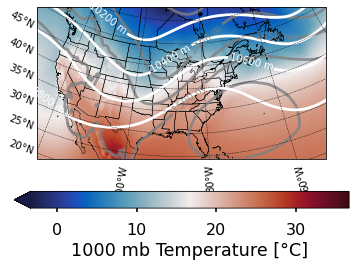

In [4]:
""" Plot IVT, Z500 and SLP """
clat, clon = 41.8781, 360-87.6298

projection = cartopy.crs.LambertConformal(central_latitude = blat, central_longitude = blon)
#projection = cartopy.crs.Orthographic(central_latitude = blat, central_longitude = blon)
transform = cartopy.crs.PlateCarree()

fig, ax = plt.subplots(subplot_kw = dict(projection = projection))

ax.set_extent([blon - half_lon_width, blon + half_lon_width, blat - half_lat_width, blat + half_lat_width], crs = cartopy.crs.PlateCarree())

#CS = slp.plot.contour(ax = ax, transform = transform, colors = "darkblue", linewidths = 4, levels = [1006.3], alpha = 0.5)

#iwv.plot(ax = ax, transform = transform,cmap = cmocean.cm.matter,
#         cbar_kwargs = dict(label = "Integrated Water Vapor [cm]", orientation = 'horizontal'))
# set the midpoint of the colorbar to the temperature at bloomington
level = 1000
tmid = float(T.sel(latitude = clat, longitude = clon, level = level, method = 'nearest').values)
tspan = 20
T.sel(level = level).plot(ax = ax, transform = transform, cmap = cmocean.cm.balance,
                       vmin = tmid-tspan, vmax = tmid+tspan, 
                        cbar_kwargs = dict(label = f"{level} mb Temperature [°C]", orientation = 'horizontal'))

CS = Z.sel(level = 850).plot.contour(ax = ax, transform = transform, colors = "gray", alpha = 0.8)
fmt = lambda x : f"{int(x)} m"
ax.clabel(CS, CS.levels, inline=True, fmt=fmt)#, fontsize=10)

#CS = Z.sel(level = 500).plot.contour(ax = ax, transform = transform, colors = "white")
#ax.clabel(CS, CS.levels, inline=True, fmt=fmt)#, fontsize=10)

CS = Z.sel(level = 250).plot.contour(ax = ax, transform = transform, colors = "white")
ax.clabel(CS, CS.levels, inline=True, fmt=fmt)#, fontsize=10)

ax.gridlines(auto_inline = False, draw_labels = dict(bottom="x", left="y"), linewidth = 0.5, alpha = 0.8, color = 'black', linestyle = '--')
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.set_title("")
                       
plt.show()                       

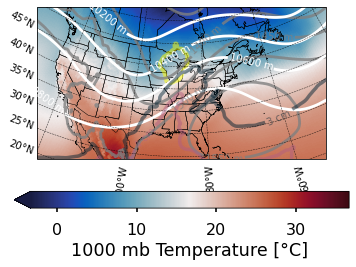

In [5]:
""" Plot IVT, Z500 and SLP """
clat, clon = 41.8781, 360-87.6298

projection = cartopy.crs.LambertConformal(central_latitude = blat, central_longitude = blon)
#projection = cartopy.crs.Orthographic(central_latitude = blat, central_longitude = blon)
transform = cartopy.crs.PlateCarree()

fig, ax = plt.subplots(subplot_kw = dict(projection = projection))

ax.set_extent([blon - half_lon_width, blon + half_lon_width, blat - half_lat_width, blat + half_lat_width], crs = cartopy.crs.PlateCarree())

CS = slp.plot.contour(ax = ax, transform = transform, colors = "yellow", linewidths = 4, levels = [1006.3], alpha = 0.5)

#iwv.plot(ax = ax, transform = transform,cmap = cmocean.cm.matter,
#         cbar_kwargs = dict(label = "Integrated Water Vapor [cm]", orientation = 'horizontal'))
# set the midpoint of the colorbar to the temperature at bloomington
level = 1000
tmid = float(T.sel(latitude = clat, longitude = clon, level = level, method = 'nearest').values)
tspan = 20
T.sel(level = level).plot(ax = ax, transform = transform, cmap = cmocean.cm.balance,
                       vmin = tmid-tspan, vmax = tmid+tspan, 
                        cbar_kwargs = dict(label = f"{level} mb Temperature [°C]", orientation = 'horizontal'))

CS = Z.sel(level = 850).plot.contour(ax = ax, transform = transform, colors = "gray", alpha = 0.8)
fmt = lambda x : f"{int(x)} m"
ax.clabel(CS, CS.levels, inline=True, fmt=fmt)#, fontsize=10)

#CS = Z.sel(level = 500).plot.contour(ax = ax, transform = transform, colors = "white")
#ax.clabel(CS, CS.levels, inline=True, fmt=fmt)#, fontsize=10)

CS = Z.sel(level = 250).plot.contour(ax = ax, transform = transform, colors = "white")
ax.clabel(CS, CS.levels, inline=True, fmt=fmt)#, fontsize=10)


CS = iwv.plot.contour(ax = ax, transform = transform, cmap = cmocean.cm.thermal,
                      levels = np.arange(3,6), linewidths = 3.5, alpha = 0.5,
                     linestyles = '-')
fmt = lambda x : f"{int(x)} cm"
ax.clabel(CS, CS.levels, inline=True, fmt=fmt)#, fontsize=10)

ax.gridlines(auto_inline = False, draw_labels = dict(bottom="x", left="y"), linewidth = 0.5, alpha = 0.8, color = 'black', linestyle = '--')
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.set_title("")
                       
plt.show()                       

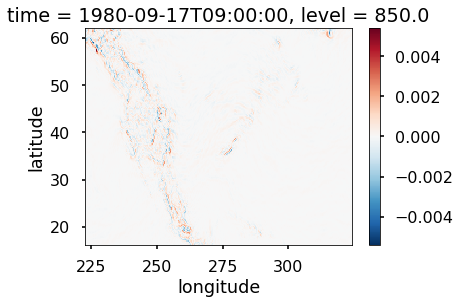

In [6]:
""" Calculate the temperature gradient """
def grad(X):
    R = 63.71 # 100 * km
    dXdlon = X.differentiate('longitude')
    dXdlat = X.differentiate('latitude')
    coslat = np.cos(X.latitude*np.pi/180)
    grady = dXdlat/R
    gradx = dXdlon/(R*coslat)
    
    return gradx, grady

gradx, grady = grad(T)

abs_grad = np.sqrt(gradx**2 + grady**2)

grad_gradx, grad_grady = grad(abs_grad)

TFP = -(grad_gradx * gradx + grad_grady * grady)/abs_grad

front = TFP.sel(level = 850)
#front = front.where(front > 0.0005)
front.plot()



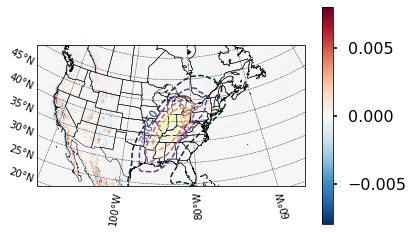

In [7]:
fig, ax = plt.subplots(subplot_kw = dict(projection = projection))

ax.set_extent([blon - half_lon_width, blon + half_lon_width, blat - half_lat_width, blat + half_lat_width], crs = cartopy.crs.PlateCarree())

CS = ivt.plot.contour(ax = ax, transform = transform, cmap = cmocean.cm.thermal,
                      levels = np.arange(250,700,100), linewidths = 1.5,
                     linestyles = '--')
ax.clabel(CS, CS.levels, inline=True)#, fmt=fmt)#, fontsize=10)

TFP.sel(level = level).plot(ax = ax, transform = transform)

ax.gridlines(auto_inline = False, draw_labels = dict(bottom="x", left="y"), linewidth = 0.5, alpha = 0.8, color = 'black', linestyle = '--')
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.set_title("")

plt.show()